In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


#preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import mode


# pipelines
from sklearn.pipeline import Pipeline



# Clustering Customer Data

In this notebook you will use your previously cleaned and preprocessing customer dataset to practice clustering.
I've implemented my own version below (of the preprocessing and cleaning) but you should feel totally free to use your own.



In [2]:
# Read in the data found in "best_one_ever_database.csv" and take a look at the head and info.
data = pd.read_csv("best_one_ever_database.csv", index_col = 'id')

In [3]:
data.head()

,first_name,last_name,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,,,
1,Jarred,Hallsworth,jhallsworth0@biblegateway.com,Non-Binary,223.109.240.148,$606.16,85349,7,NaN,3310.505486
2,Wayne,Robez,wrobez1@t.co,Male,73.174.113.87,$147.22,85336,9,NaN,2188.852818
3,Casper,Hayles,chayles2@cdc.gov,Male,223.249.117.173,$801.97,85350,4,0.597445,2640.499644
4,Mandie,Szepe,mszepe3@lulu.com,Female,31.143.95.228,$336.77,85364,4,NaN,2872.580992
5,Noam,Cecely,ncecely4@elegantthemes.com,Male,63.71.174.230,$757.45,85369,8,0.127835,2728.008966


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   first_name                 2000 non-null   object 
 1   last_name                  2000 non-null   object 
 2   email                      2000 non-null   object 
 3   gender                     2000 non-null   object 
 4   ip_address                 2000 non-null   object 
 5   sales                      2000 non-null   object 
 6   zip_code                   2000 non-null   int64  
 7   total_num_of_transactions  2000 non-null   int64  
 8   prob_of_rebuy              1538 non-null   float64
 9   money_spent                1690 non-null   float64
dtypes: float64(2), int64(2), object(6)
memory usage: 171.9+ KB


# Cleaning The Data



In [5]:
# drop the name columns using pandas.drop()

X = data.drop(labels = ['first_name','last_name'], axis = 1)

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   email                      2000 non-null   object 
 1   gender                     2000 non-null   object 
 2   ip_address                 2000 non-null   object 
 3   sales                      2000 non-null   object 
 4   zip_code                   2000 non-null   int64  
 5   total_num_of_transactions  2000 non-null   int64  
 6   prob_of_rebuy              1538 non-null   float64
 7   money_spent                1690 non-null   float64
dtypes: float64(2), int64(2), object(4)
memory usage: 140.6+ KB


### Transform string columns into useful features


In [7]:
def strip_dollar(x):
    return x[1:]

In [8]:
# apply the function to the column and assign it back to the column (it does not work inplace)
X.sales = X.sales.apply(strip_dollar)

# cast the column to a floating point type - this is very important, otherwise it will be
# an object type column that we cannot do arithmetic on the column
X.sales = X.sales.astype('float32')

In [9]:
X.head()

,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,
1,jhallsworth0@biblegateway.com,Non-Binary,223.109.240.148,606.159973,85349,7,NaN,3310.505486
2,wrobez1@t.co,Male,73.174.113.87,147.220001,85336,9,NaN,2188.852818
3,chayles2@cdc.gov,Male,223.249.117.173,801.969971,85350,4,0.597445,2640.499644
4,mszepe3@lulu.com,Female,31.143.95.228,336.769989,85364,4,NaN,2872.580992
5,ncecely4@elegantthemes.com,Male,63.71.174.230,757.450012,85369,8,0.127835,2728.008966


In [10]:
# define functions to apply to the dataframe
def strip_emails(x):
    at = x.find('@')
    return x[at+1:]

test_email = 'thisismymail@gmail.com'
print(strip_emails(test_email))

gmail.com


In [11]:
# apply the function to the column and assign it back to the column (it does not work inplace)
X.email = X.email.apply(strip_emails)
X.head()

,email,gender,ip_address,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent
id,,,,,,,,
1,biblegateway.com,Non-Binary,223.109.240.148,606.159973,85349,7,NaN,3310.505486
2,t.co,Male,73.174.113.87,147.220001,85336,9,NaN,2188.852818
3,cdc.gov,Male,223.249.117.173,801.969971,85350,4,0.597445,2640.499644
4,lulu.com,Female,31.143.95.228,336.769989,85364,4,NaN,2872.580992
5,elegantthemes.com,Male,63.71.174.230,757.450012,85369,8,0.127835,2728.008966


# Is the email column going to be worth it?
Let's take a look at this email column and decide if it could help us or not.


In [12]:
# how many unique domains are there?
counts = X.email.value_counts()

In [13]:
print(counts.values)

[10 10 10 10 10 10  9  9  9  9  9  9  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  4  4  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3

No, it doesn't seem like this column will be very helpful as it's quite spread out. There are 490 unique values and no one value has a majority, so let's just leave it to the side for now. We can always come back to it later.

In [14]:
# we make sure to copy it over and save it for later.
emails = X.email.copy()
X.drop('email', axis=1, inplace = True)

In [15]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     2000 non-null   object 
 1   ip_address                 2000 non-null   object 
 2   sales                      2000 non-null   float32
 3   zip_code                   2000 non-null   int64  
 4   total_num_of_transactions  2000 non-null   int64  
 5   prob_of_rebuy              1538 non-null   float64
 6   money_spent                1690 non-null   float64
dtypes: float32(1), float64(2), int64(2), object(2)
memory usage: 117.2+ KB


## Splitting the IP Address
We now need to split up the IP address, we will use Pandas's built in str method for this.

In [16]:
X[['first_ip','second_ip','third_ip','fourth_ip']] = X.ip_address.str.split(pat=".", expand=True)

In [17]:
# now we cast the columns as floats
X[['first_ip','second_ip','third_ip','fourth_ip']] = X[['first_ip','second_ip','third_ip','fourth_ip']].astype('float32')
# we also drop the original column
X.drop('ip_address', axis=1, inplace=True)

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gender                     2000 non-null   object 
 1   sales                      2000 non-null   float32
 2   zip_code                   2000 non-null   int64  
 3   total_num_of_transactions  2000 non-null   int64  
 4   prob_of_rebuy              1538 non-null   float64
 5   money_spent                1690 non-null   float64
 6   first_ip                   2000 non-null   float32
 7   second_ip                  2000 non-null   float32
 8   third_ip                   2000 non-null   float32
 9   fourth_ip                  2000 non-null   float32
dtypes: float32(5), float64(2), int64(2), object(1)
memory usage: 132.8+ KB


# One Hot Encoding

Ok we are almost done, we just have to convert the gender column into something integer that we can use. We will use one-hot-encoding since gender is a categorical variable.

Pandas has a `get_dummies()` function that will be very useful.


In [19]:
X.gender.value_counts()

gender
Male          775
Female        725
Non-Binary    500
Name: count, dtype: int64

In [20]:
dumbdumbs = pd.get_dummies(X['gender'])
X= pd.concat((X,dumbdumbs), axis = 1)
X.drop(['gender'], axis = 1, inplace=True)
X.head()

,sales,zip_code,total_num_of_transactions,prob_of_rebuy,money_spent,first_ip,second_ip,third_ip,fourth_ip,Female,Male,Non-Binary
id,,,,,,,,,,,,
1,606.159973,85349,7,NaN,3310.505486,223.0,109.0,240.0,148.0,False,False,True
2,147.220001,85336,9,NaN,2188.852818,73.0,174.0,113.0,87.0,False,True,False
3,801.969971,85350,4,0.597445,2640.499644,223.0,249.0,117.0,173.0,False,True,False
4,336.769989,85364,4,NaN,2872.580992,31.0,143.0,95.0,228.0,True,False,False
5,757.450012,85369,8,0.127835,2728.008966,63.0,71.0,174.0,230.0,False,True,False


In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 1 to 2000
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales                      2000 non-null   float32
 1   zip_code                   2000 non-null   int64  
 2   total_num_of_transactions  2000 non-null   int64  
 3   prob_of_rebuy              1538 non-null   float64
 4   money_spent                1690 non-null   float64
 5   first_ip                   2000 non-null   float32
 6   second_ip                  2000 non-null   float32
 7   third_ip                   2000 non-null   float32
 8   fourth_ip                  2000 non-null   float32
 9   Female                     2000 non-null   bool   
 10  Male                       2000 non-null   bool   
 11  Non-Binary                 2000 non-null   bool   
dtypes: bool(3), float32(5), float64(2), int64(2)
memory usage: 123.0 KB


# Data Preprocessing Stage 2 - Missing values



In [22]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [23]:
X_ = imp.fit_transform(X)

In [24]:
X= pd.DataFrame(X_, columns=X.columns)

In [25]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   sales                      2000 non-null   float64
 1   zip_code                   2000 non-null   float64
 2   total_num_of_transactions  2000 non-null   float64
 3   prob_of_rebuy              2000 non-null   float64
 4   money_spent                2000 non-null   float64
 5   first_ip                   2000 non-null   float64
 6   second_ip                  2000 non-null   float64
 7   third_ip                   2000 non-null   float64
 8   fourth_ip                  2000 non-null   float64
 9   Female                     2000 non-null   float64
 10  Male                       2000 non-null   float64
 11  Non-Binary                 2000 non-null   float64
dtypes: float64(12)
memory usage: 187.6 KB


# Clustering

Ok, now we have our customer data all ready to go. We have done all the hard work of preprocessing. Let's feed this data into our algorithms!

We'll try two different clustering algorithms. K-means and DB-scan.


Our goal is to cluster the data and learn what kinds of customers we have, are they related to one another at all? In order to do this we should try some clustering

# Cluster with  K-means

Let's just make some clusters and evaluate it with their silhouette score. A reminder about the silhouette score

>The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

From : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score

Your Job:
Run a k-means loop on clusters 2-n (you decide how many you want to try!) and see which # of clusters is best.

You should scale the data first since we are hunting for clusters we definitely want the dimensions to be on the same scale (remember that distance means everything here!).

#### Note:
In an effort to slowly remove your training wheels, I have not important everything you need to accomplish your tasks here.


In [26]:
# import what you need
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [47]:
# scale your data with a scaler of your choice
scaler = StandardScaler()
Y = scaler.fit_transform(X)

In [48]:
# create a k-means estimator and fit it.
kmeans = KMeans()
kmeans.fit(Y)

C:\Users\satvm\miniconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans()

In [49]:
kmeans.labels_

array([3, 2, 2, ..., 7, 1, 6])

In [50]:
# print out the silhouette score
silhouette_score(Y, kmeans.labels_)

0.08771859188959953

In [51]:
# run a loop between 2-N (your choice for N!) and print this guy out.
for n in range(2, 11):
    kmeans = KMeans(n_clusters=n, n_init=10)
    kmeans.fit(Y)
    
    # Calculate the silhouette score for the current clustering result
    labels = kmeans.labels_
    score = silhouette_score(Y, labels)
    
    print(f"Silhouette Score for {n} clusters: {score:.2f}")


Silhouette Score for 2 clusters: 0.13
Silhouette Score for 3 clusters: 0.19
Silhouette Score for 4 clusters: 0.14
Silhouette Score for 5 clusters: 0.12
Silhouette Score for 6 clusters: 0.11
Silhouette Score for 7 clusters: 0.09
Silhouette Score for 8 clusters: 0.09
Silhouette Score for 9 clusters: 0.09
Silhouette Score for 10 clusters: 0.09


### Cluster Discussion

Ok, so we found the best number of clusters according to the silhouette score.  So what? I mean to say, what do we do with that? We know that according the silhouette score this is the best, but... even if that's correct, _now what_? How do we use these clusters to help us run our business?
How can we learn what these clusters represent?

I can think of one thing to check

1. Look at the feature values of the cluster centroids.

Recall that every cluster in kmeans has a centroid. That centroid is the very _center_ of the cluster, so we can look at the feature values of the centroids and see what they tell us. In theory the centroids represent the cluster (generally). 

We can look at the cluster centroids right now.  Let's examine then with a barplot.

I'm going to give you some code help here.

In [52]:
# fit a kmeans cluster with desired number of components
kmean2 = KMeans(n_clusters=3, n_init=10)
kmean2.fit(Y)

KMeans(n_clusters=3, n_init=10)

In [53]:
# look for the centers of your clusters.  
# Hint: your kmeans object has an attribute you'd want to use
centroids = kmean2.cluster_centers_
print(centroids)

[[ 4.13769256e-02 -2.57378564e-02 -1.01718633e-03 -1.86939575e-02
  -3.50383462e-02 -1.25077317e-02  1.53321053e-02 -3.08946489e-02
  -1.15358160e-02 -7.54073903e-01  1.25723711e+00 -5.77350269e-01]
 [-2.08022379e-02  5.91840088e-02 -1.24893583e-02  1.14703470e-03
   6.78961682e-03 -1.92466136e-02 -6.16755144e-03  5.52603075e-02
   2.07500298e-02  1.32612997e+00 -7.95394909e-01 -5.77350269e-01]
 [-3.39709897e-02 -4.59231353e-02  1.96862083e-02  2.73124339e-02
   4.44644922e-02  4.72945738e-02 -1.48218137e-02 -3.22407400e-02
  -1.22070285e-02 -7.54073903e-01 -7.95394909e-01  1.73205081e+00]]


In [54]:
# my gift to you, use it to plot your centers
def plot_centroids(centers):
    pd.DataFrame(centers, columns = X.columns).plot(kind = 'bar', figsize = (12,6))
    plt.legend(loc='best', bbox_to_anchor=(0.8, 0.1, 0.5, 0.5)); # bbox is (x,y, width, height)


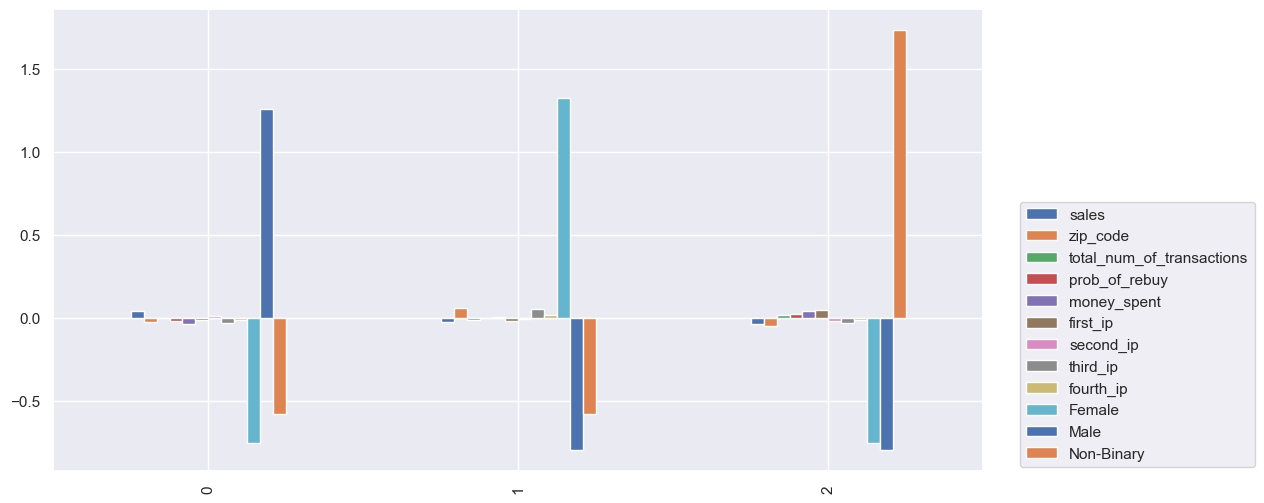

In [55]:
plot_centroids(centroids)

# Examine your centroids

What does your graph tell you?
What features are the most important and contributing towards the clusters?

Extra-Credit: Rerun your clustering algorithm with a _different_ scaling method and re-examine your centroid features. Do they change? Why? What does it mean?

# DB-Scan

Let's now try DB-scan. Remember we have three parameters we need to set
1. `eps` the radius of our circle that we will search in
2. `min_samples` the minimum number of samples we need to find within our radius to call it a cluster
3. `metric` our distance metric.  Defaults to Euclidean (L2-norm).

So, we get to fiddle with 3 parameters, but we don't have to worry about "how many" clusters to look for, db-scan will decide for us.

Go ahead and run it!
What is the best eps / min_samples ?
What gets you the best silhouette score?

In order to answer these questions we will need to figure out a few things

1. run dbscan (that's pretty easy)
2. how many clusters did it find?
3. how do we get the labels (predictions) from the dbscan object?

In [56]:
from sklearn.cluster import DBSCAN

In [131]:
# run dbscan 
# pick an eps -- how might we do this? what range are your features in?
# Your eps should be relevant to the feature space you exist in
# pick min_samples
dbscan = DBSCAN(eps=3.0,min_samples=50)

#### ok, now you fit a dbscan. 
1. how do we figure out how many clusters it found?
DBscan has 3 main attributes, 1

>**core_sample_indices_ndarray of shape (n_core_samples,)**
Indices of core samples.

>**components_ndarray of shape (n_core_samples, n_features)**
Copy of each core sample found by training.

>**labels_ndarray of shape (n_samples)**
Cluster labels for each point in the dataset given to fit(). Noisy samples are given the label -1.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

Go ahead and look at those attributes. Print them out. Which one will help us figure out how many clusters DBscan found?

Also pay attention to changing `eps`, if `eps` is too small what happens? Too large?

In [132]:
dbscan.fit(Y)

DBSCAN(eps=3.0, min_samples=50)

In [133]:
dbscan.core_sample_indices_

array([   1,    2,    3, ..., 1997, 1998, 1999], dtype=int64)

In [134]:
dbscan.components_

array([[-1.53938602, -1.57554973,  1.25242612, ..., -0.7540739 ,
         1.25723711, -0.57735027],
       [ 0.94928044, -1.57081911, -0.48971621, ..., -0.7540739 ,
         1.25723711, -0.57735027],
       [-0.81891757, -1.5660885 , -0.48971621, ...,  1.32612997,
        -0.79539491, -0.57735027],
       ...,
       [ 0.40251507,  1.15739499,  1.60085458, ..., -0.7540739 ,
         1.25723711, -0.57735027],
       [ 0.62547844,  1.15165067,  0.55556919, ..., -0.7540739 ,
        -0.79539491,  1.73205081],
       [-0.72389403,  1.09724858, -0.14128774, ...,  1.32612997,
        -0.79539491, -0.57735027]])

In [140]:
dbscan.labels_

array([2, 0, 0, ..., 0, 2, 1], dtype=int64)

In [136]:
silhouette_score(Y, dbscan.labels_)

0.19026497368410303

## Calculate the Silhouette Score

In order to perform the silhouette score we need the labels (that's pretty easy they are given to us), however we should _exclude_ the -1's because they represent points that are _not_ in a cluster. So they are basically discarded. We should probably collect those somewhere and else and see how large that number is. But it should not be part of the silhouette core.

So
1. seperate out the points which have the label `-1`

Then after we have done that, we can calcluate the silhouette score easily. 
#### NOTE
DBscan in scikit-learn is implemented with the notion of "core samples".  From the [documentation:](https://scikit-learn.org/stable/modules/clustering.html#dbscan)
>More formally, we define a core sample as being a sample in the dataset such that there exist min_samples other samples within a distance of eps, which are defined as neighbors of the core sample. This tells us that the core sample is in a dense area of the vector space. A cluster is a set of core samples that can be built by recursively taking a core sample, finding all of its neighbors that are core samples, finding all of their neighbors that are core samples, and so on. **A cluster also has a set of non-core samples, which are samples that are neighbors of a core sample in the cluster but are not themselves core samples.** Intuitively, these samples are on the fringes of a cluster.

This means that the attributes `components` and `core_sample_indices` will only return core samples, for us to get all the points _within_ the cluster we will have to rely on the labels

### Number of clusters?
But what about the # of clusters? How many did we find and how many in each cluster? We need to examine the labels again, but this time count the unique ones and also count how many of each unique we have.

### Goal
Run our little line of code, which gives both the score and # of clusters.

`print(f"The number of clusters is {num_clusters} and the Silhouette score is {silhouette_score(x_scaled, dbscan.labels_)}")`


Oh! we also should probably add
`print(f"The number of discarded points was {}")`


In [147]:
## remove the -1's from the labels.
## you also will need to remove the corresponding x_scaled samples so you can compute the silhouette score.
# you can use numpy boolean indexing masks for this.
labels = dbscan.labels_[dbscan.labels_!=-1]
x_points = Y[dbscan.labels_!=-1]

In [148]:
labels.shape

(1993,)

In [149]:
x_points.shape

(1993, 12)

In [150]:
## ok if you have the labels and x's without -1's you can actually computer the Silhouette score now
silhouette_score(x_points, labels)

0.19199831363431938

In [153]:
## how many clusters are there though?
## you need to figure out how many unique labels there are, and also it would be nice to know
## how many points are in each cluster
uniques, counts = np.unique(labels, return_counts=True)
print(uniques)
print(counts)

[0 1 2]
[774 723 496]


In [ ]:
# How does it compare?
Did your DBSCAN find similar clusters to k-means? Same number of clusters? More? Less?
What about the silhouette score? Better or worse?

## Next, wed like to look at the centroids.
Actually, DBSCAN doesnt have centroids naturally the same way k-means does. But we can compute it ourselves.
We would need to isolate the points of each group, and then just take the mean column-wise; that would represent the centroid of each cluster.
You can do this with a numpy mask.

In [165]:
# plot your DBScan Centroids
centers = []
for i in uniques:
    centers.append(x_points[labels==i].mean(axis=0))
    
dbcenters = np.array(centers)

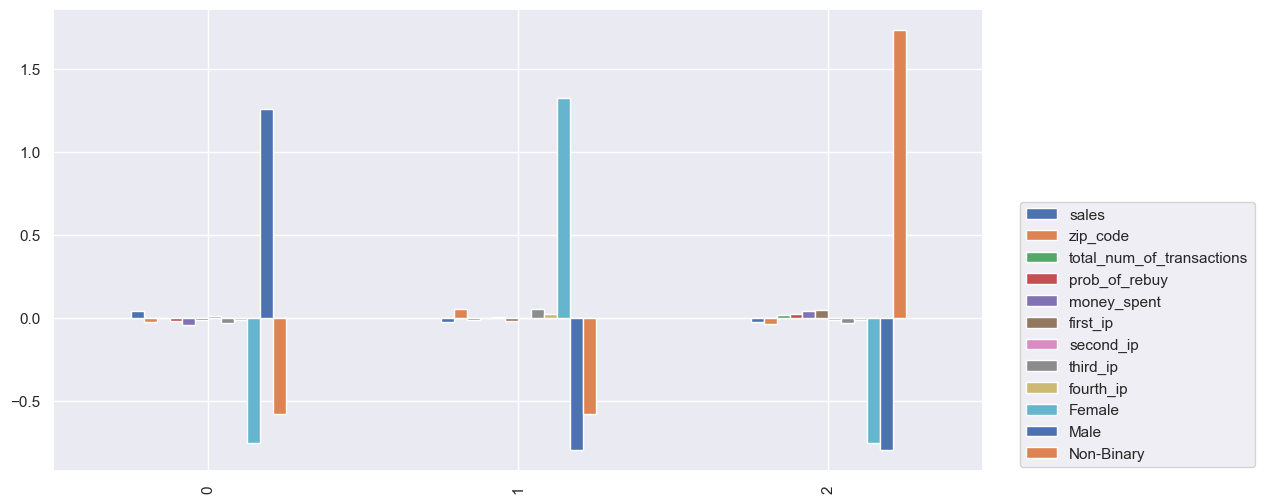

In [166]:
plot_centroids(dbcenters)

# How do your centroids compare?

Did you find similar clusters? Dissimilar?
